# Outbrain click prediction

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
p = sns.color_palette()

print '# File sizes'
for f in os.listdir('../data'):
    if 'zip' not in f:
        print f.ljust(30) + str(round(os.path.getsize('../data/' + f) / 1000000, 2)) + 'MB'

# File sizes
promoted_content.csv          13.0MB
clicks_train.csv              1486.0MB
sample_submission.csv         273.0MB
documents_topics.csv          339.0MB
events.csv                    1208.0MB
documents_meta.csv            89.0MB
documents_categories.csv      118.0MB
clicks_test.csv               506.0MB
documents_entities.csv        324.0MB
page_views_sample.csv         454.0MB


In [27]:
df_train = pd.read_csv('../data/clicks_train.csv')
df_test = pd.read_csv('../data/clicks_test.csv')

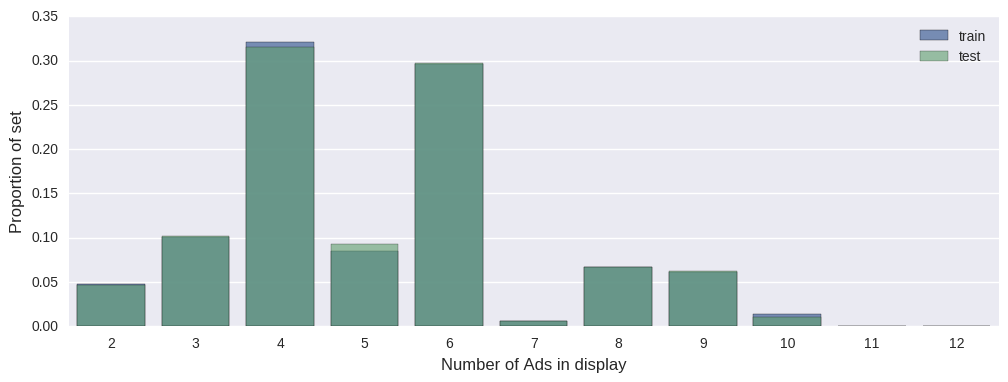

In [29]:
sizes_train = df_train.groupby('display_id')['ad_id'].count().value_counts()
sizes_test = df_test.groupby('display_id')['ad_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

In [30]:
print df_train.groupby('display_id')['ad_id']

In [31]:
 df_train.groupby('display_id')

Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


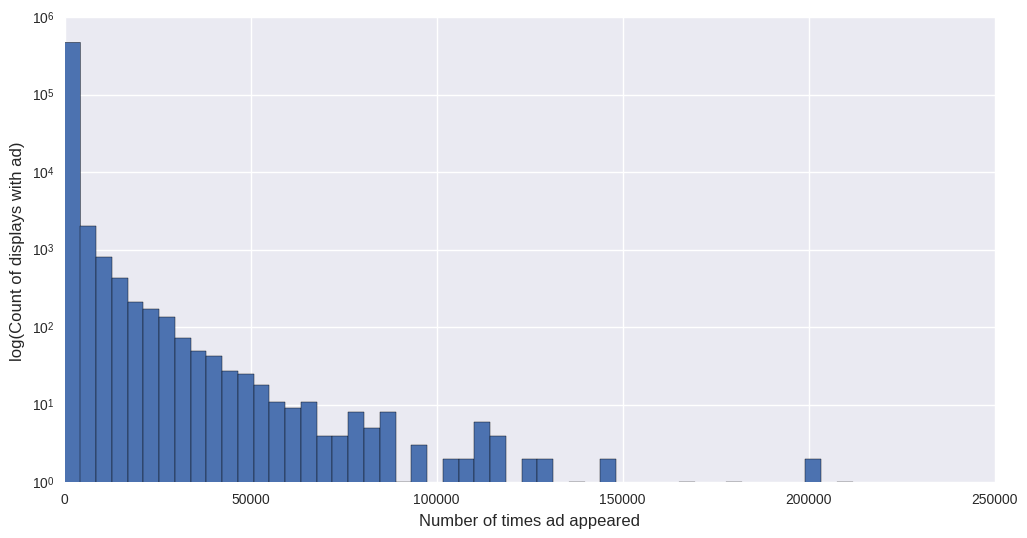

In [8]:
ad_usage_train = df_train.groupby('ad_id')['ad_id'].count()

for i in [2, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

In [18]:
ad_prop = len(set(df_test.ad_id.unique()).intersection(df_train.ad_id.unique())) / float(len(df_test.ad_id.unique()))
print('Proportion of test ads in test that are in training: {}%'.format(round(ad_prop * 100, 2)))

Proportion of test ads in test that are in training: 82.87%


In [20]:
try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

events = pd.read_csv('../data/events.csv')
print('Shape:', events.shape)
print('Columns', events.columns.tolist())
events.head()

/home/ryan/Libraries/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


('Shape:', (23120126, 6))
('Columns', ['display_id', 'uuid', 'document_id', 'timestamp', 'platform', 'geo_location'])


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [21]:
plat = events.platform.value_counts()

print(plat)
print('\nUnique values of platform:', events.platform.unique())

2     10684579
1      8747280
3      3032907
2       291699
1       279988
3        83668
\N           5
Name: platform, dtype: int64
('\nUnique values of platform:', array([3, 2, 1, '2', '1', '3', '\\N'], dtype=object))


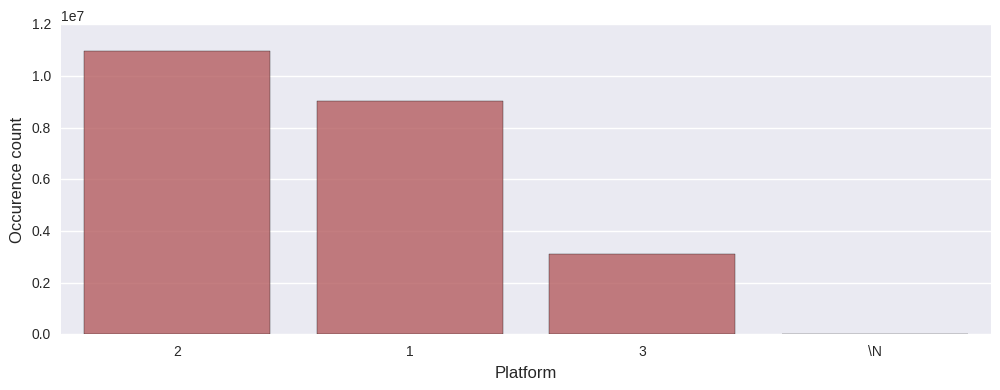

In [22]:
events.platform = events.platform.astype(str)
plat = events.platform.value_counts()

plt.figure(figsize=(12,4))
sns.barplot(plat.index, plat.values, alpha=0.8, color=p[2])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence count', fontsize=12)

uuid
ef7761dd22277c    38
45d23867dbe3b3    38
c0bd502c7a479f    42
2759b057797f02    46
b88553e3a2aa29    49
Name: uuid, dtype: int64
Users that appear less than 2 times: 88.42%
Users that appear less than 5 times: 99.51%
Users that appear less than 10 times: 99.96%


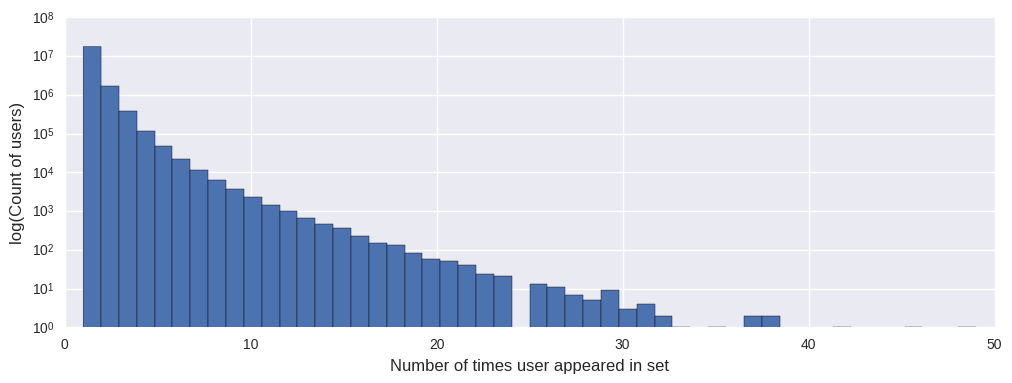

In [23]:
uuid_counts = events.groupby('uuid')['uuid'].count().sort_values()

print(uuid_counts.tail())

for i in [2, 5, 10]:
    print('Users that appear less than {} times: {}%'.format(i, round((uuid_counts < i).mean() * 100, 2)))
    
plt.figure(figsize=(12, 4))
plt.hist(uuid_counts.values, bins=50, log=True)
plt.xlabel('Number of times user appeared in set', fontsize=12)
plt.ylabel('log(Count of users)', fontsize=12)
plt.show()

In [25]:
try:del events
except:pass;gc.collect()

topics = pd.read_csv('../data/documents_topics.csv')
print('Columns:',topics.columns.tolist())
print('Number of unique topics:', len(topics.topic_id.unique()))

topics.head()

('Columns:', ['document_id', 'topic_id', 'confidence_level'])
('Number of unique topics:', 300)


,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450
